Data set from https://www.physionet.org/content/eegmmidb/1.0.0/ recordings from 109 volunteers 

### **Experiment Protocol**

performed 14 experimental runs:
1. **one-minute** baseline runs with eyes open.
2. **one-minute** baseline runs with eyes closed.
3. Task 1 : **two-minute** open and close left or right fist
4. Task 2 : **two-minute** imagine opening and closing left or right fist
5. Task 3 : **two-minute** open and close both fists or both feet
6. Task 4 : **two-minute** imagine opening and closing both fists or both feet
7. Task 1
8. Task 2
9. Task 3
10. Task 4
11. Task 1
12. Task 2
13. Task 3
14. Task 4

**Annotation three codes** (T0, T1, or T2):
- T0 corresponds to rest
- T1 corresponds to onset of motion (real or imagined) of
    - the left fist (in runs 3, 4, 7, 8, 11, and 12)
    - both fists (in runs 5, 6, 9, 10, 13, and 14)
- T2 corresponds to onset of motion (real or imagined) of
    - the right fist (in runs 3, 4, 7, 8, 11, and 12)
    - both feet (in runs 5, 6, 9, 10, 13, and 14)

# **Offline processing of Motor Imagery**

## **Pre-Processing**

### **Load Data**

In [208]:
%matplotlib inline
import mne
import os
import pyedflib
import pandas as pd
import numpy as np
import seaborn as sns
from mne.io import read_raw_edf, RawArray, concatenate_raws
from mne.stats import permutation_cluster_1samp_test as pcluster_test
import warnings
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

In [209]:
# --- Data Details --- 
subject_id = ["001", "010", "014"]
task_id = ["04", "08", "12"]

# --- Set Montage ---
montage_name = 'standard_1020'

# --- Set Channels Select ---
chans_selected = ['C5','C3','C1','Cz','C2','C4','C6']

In [210]:
# --- Dataset Path --- 
dataset_path = "Online Dataset/eeg-motor-movementimagery-dataset-1.0.0/files"

# --- Full Path ---
filenames = []
for i in range(len(subject_id)):
    for j in range(len(task_id)):
        filenames.append("S"+subject_id[i]+"/S"+subject_id[i]+"R"+task_id[j]+".edf")
        
path = [os.path.join(dataset_path, filename).replace("\\", "/") for filename in filenames]

# --- Read EDF Files ---
subject_raws = []
for file_path in path:
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=RuntimeWarning)
        data = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
    subject_raws.append(data)

print("Path:",path)
raws_data = concatenate_raws(subject_raws)
print("RawEDF data:", raws_data)

# --- Check Signal Channels ---
with pyedflib.EdfReader(path[-1]) as edf_file:
    signal_labels = edf_file.getSignalLabels()
    print("signal_channels:", signal_labels)

Path: ['Online Dataset/eeg-motor-movementimagery-dataset-1.0.0/files/S001/S001R04.edf', 'Online Dataset/eeg-motor-movementimagery-dataset-1.0.0/files/S001/S001R08.edf', 'Online Dataset/eeg-motor-movementimagery-dataset-1.0.0/files/S001/S001R12.edf', 'Online Dataset/eeg-motor-movementimagery-dataset-1.0.0/files/S010/S010R04.edf', 'Online Dataset/eeg-motor-movementimagery-dataset-1.0.0/files/S010/S010R08.edf', 'Online Dataset/eeg-motor-movementimagery-dataset-1.0.0/files/S010/S010R12.edf', 'Online Dataset/eeg-motor-movementimagery-dataset-1.0.0/files/S014/S014R04.edf', 'Online Dataset/eeg-motor-movementimagery-dataset-1.0.0/files/S014/S014R08.edf', 'Online Dataset/eeg-motor-movementimagery-dataset-1.0.0/files/S014/S014R12.edf']
RawEDF data: <RawEDF | S001R04.edf, 64 x 178080 (1113.0 s), ~87.0 MB, data loaded>
signal_channels: ['Fc5.', 'Fc3.', 'Fc1.', 'Fcz.', 'Fc2.', 'Fc4.', 'Fc6.', 'C5..', 'C3..', 'C1..', 'Cz..', 'C2..', 'C4..', 'C6..', 'Cp5.', 'Cp3.', 'Cp1.', 'Cpz.', 'Cp2.', 'Cp4.', 'Cp

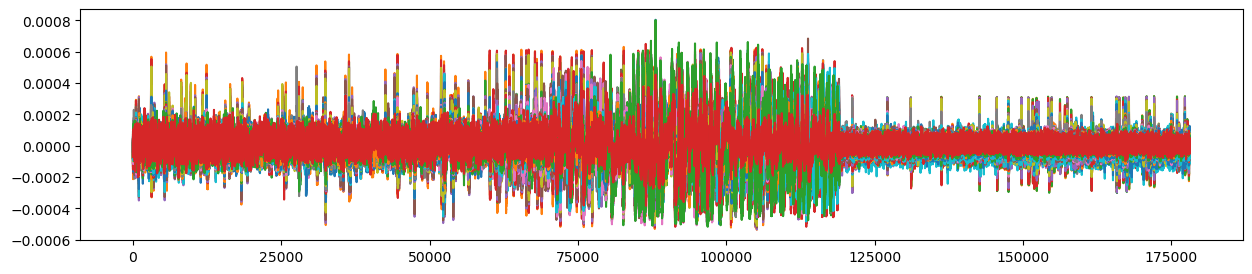

In [211]:
# --- Plot Raw Data in Time Domain ---
# raws_data.plot()
data = raws_data.get_data()
plt.figure(figsize=(15,3))
plt.plot(data.T)

Effective window size : 12.800 (s)


C:\Users\user\AppData\Local\Temp\ipykernel_37668\2751059171.py:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raws_data.compute_psd().plot();
c:\Anaconda\lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


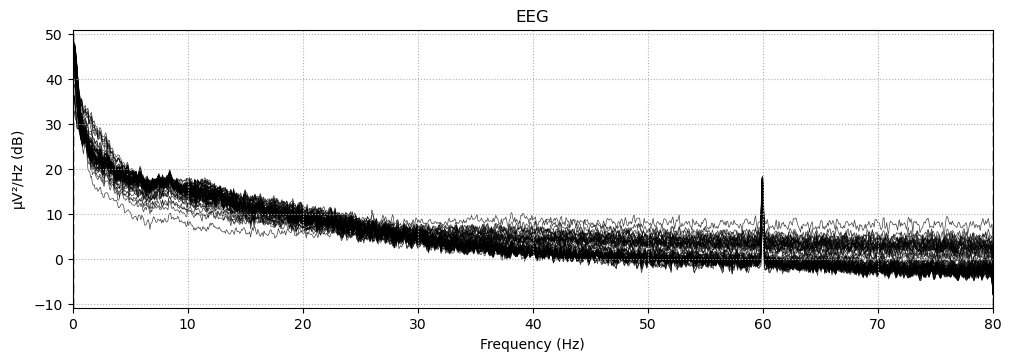

In [212]:
# --- Plot Raw Data in Frequency Domain ---
raws_data.compute_psd().plot();

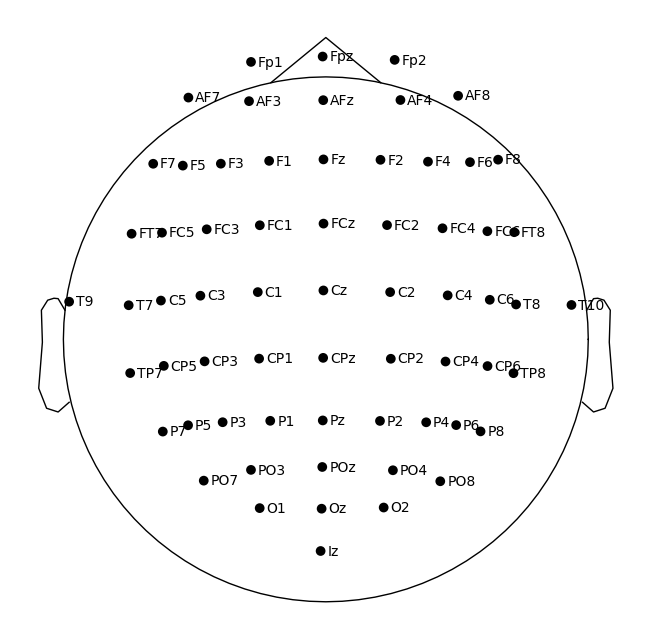

In [213]:
with open("Online Dataset/eeg-motor-movementimagery-dataset-1.0.0/files/wfdbcal", "r") as file:
    content = file.readlines()
    
chan_name = []
chan_order = []
chan_mapping = {}
order = 1
for line in content:
    parts = line.split('\t')
    channel_name = parts[0].strip()
    channel_name = channel_name.replace(".", "")
    chan_name.append(channel_name)
    order_name = "# " + str(order)
    chan_order.append(order_name)
    chan_mapping[order_name] = channel_name
    order += 1 

channel_names = [chan_mapping[f'# {i+1}'] for i in range(64)]
old_ch_names = raws_data.info['ch_names']

raws_data.rename_channels({old: new for old, new in zip(old_ch_names, channel_names)})

# Set montage
# montage = mne.channels.make_standard_montage('standard_1020')
raws_data.set_montage(montage = mne.channels.make_standard_montage(montage_name))

# Plot channel locations
raws_data.plot_sensors(show_names=True);

Effective window size : 12.800 (s)


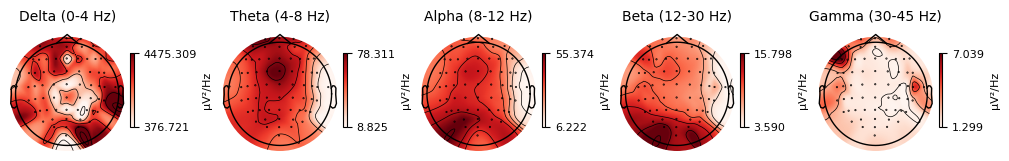

In [214]:
raws_data.compute_psd().plot_topomap();

### **Re-referencing**

Original data of brain signal (64 channels)

Effective window size : 12.800 (s)


c:\Anaconda\lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


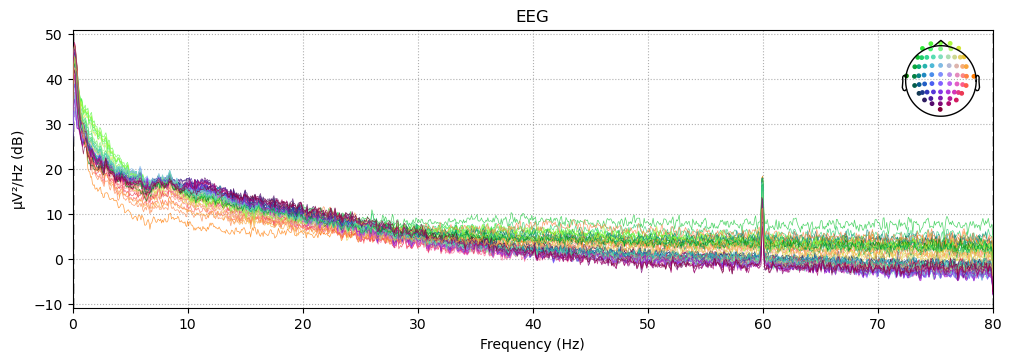

In [215]:
# --- Plot Raw Data in Time Domain ---
raws_data.compute_psd().plot();

**Common Average Reference (CAR)** for re-referancing signal 64 channels

In [216]:
# --- Apply Re-reference by Common Average Reference (CAR) ---
streams = raws_data.copy().set_eeg_reference('average', projection=True)
streams.apply_proj()

EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated


SSP projectors applied...


<RawEDF | S001R04.edf, 64 x 178080 (1113.0 s), ~87.0 MB, data loaded>

Once re-referencing is done, it's apparent that there are channels moving closer to other graphs, as seen clearly. For instance, the purple graph overlaps and closely aligns with other graphs significantly.

Effective window size : 12.800 (s)


c:\Anaconda\lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


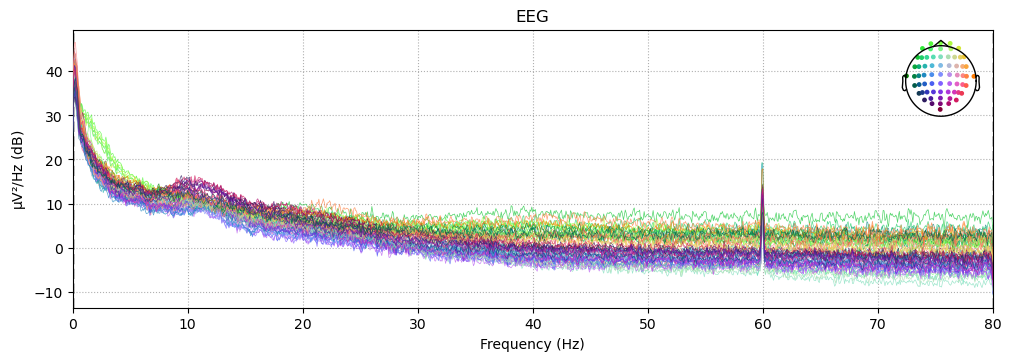

In [217]:
streams.compute_psd().plot();

### **Filtering**

**Infinite Impulse Response (IIR)** for filtering signal
- Butterworth Filters and 6 order
- Low frequency = 8.0
- High frequency = 15.0

In [218]:
stream_filter = streams.copy().filter(l_freq=8.0, h_freq=15.0, method = 'iir', iir_params= {"order": 6, "ftype":'butter'})

Filtering raw data in 9 contiguous segments
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 24 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB


Effective window size : 12.800 (s)


c:\Anaconda\lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


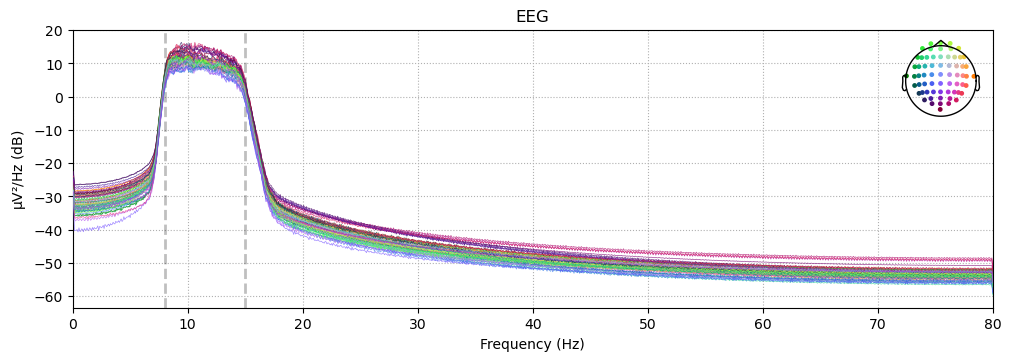

In [219]:
stream_filter.compute_psd().plot();
# stream_filter.plot();

### **Artifact rejection and correction**

**Independent Component Analysis (ICA)** for remove artifact from eye blink or other artifact 

In [220]:
# --- Apply ICA ---
ica = mne.preprocessing.ICA(n_components=63, random_state=97, max_iter=800)
ica.fit(stream_filter.copy())

Fitting ICA to data using 64 channels (please be patient, this may take a while)


    Applying projection operator with 1 vector (pre-whitener computation)
    Applying projection operator with 1 vector (pre-whitener application)
Selecting by number: 63 components
    Applying projection operator with 1 vector (pre-whitener application)
Fitting ICA took 16.3s.


<ICA | raw data decomposition, method: fastica (fit in 94 iterations on 178080 samples), 63 ICA components (64 PCA components available), channel types: eeg, no sources marked for exclusion>

plot topographies of the ICA components to observe and identify which components are likely to be artifacts, in order to use them for removing those specific components, for the purpose of artifact removal

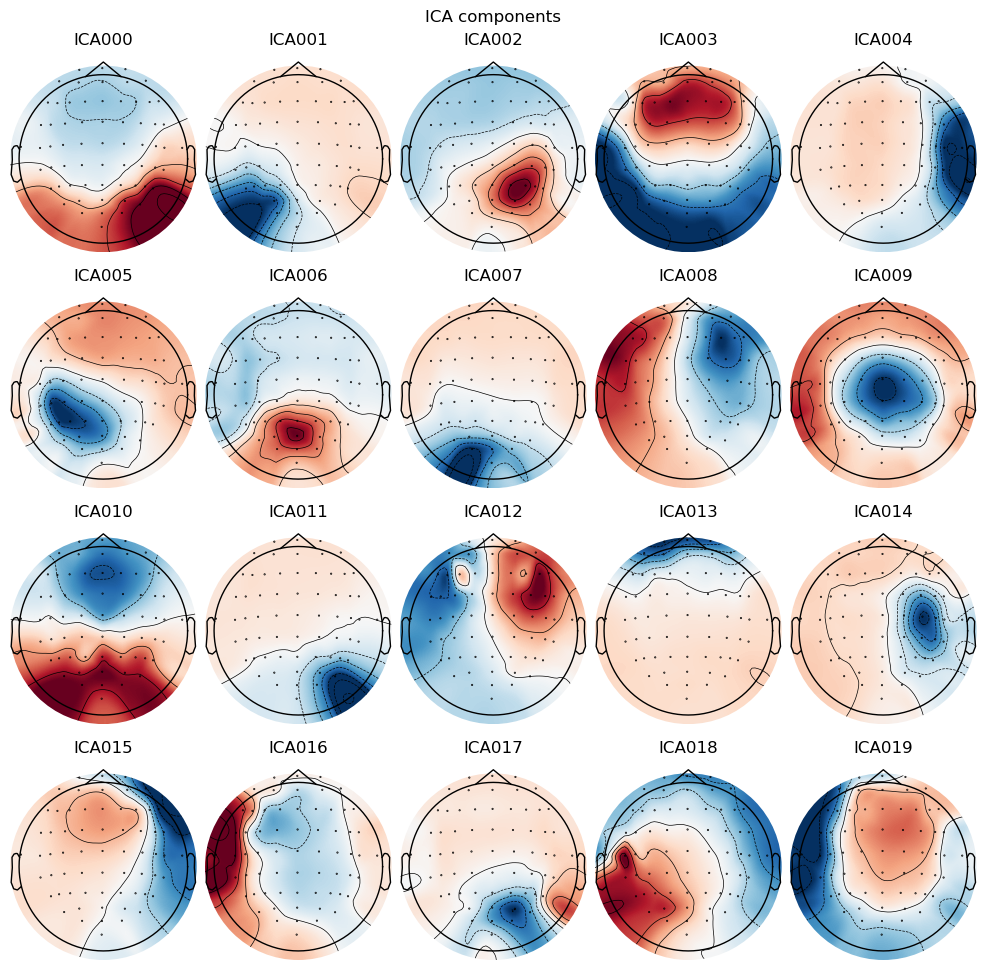

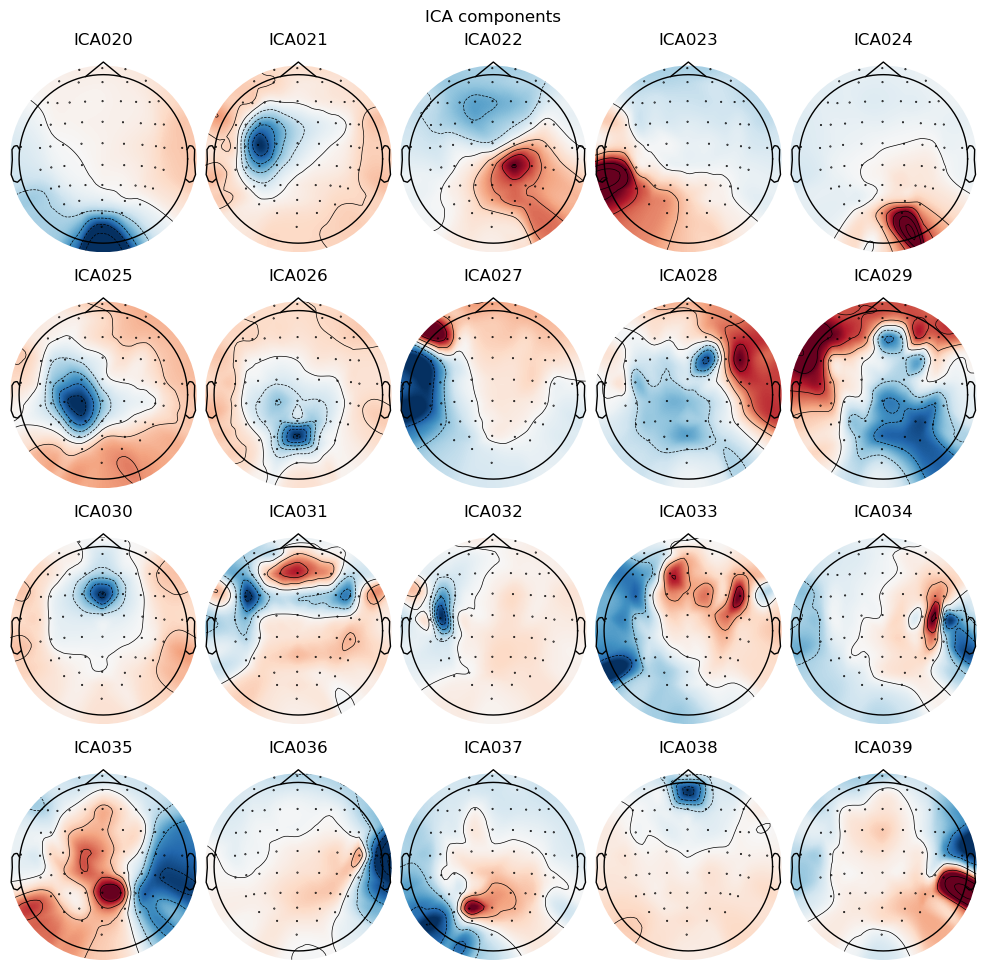

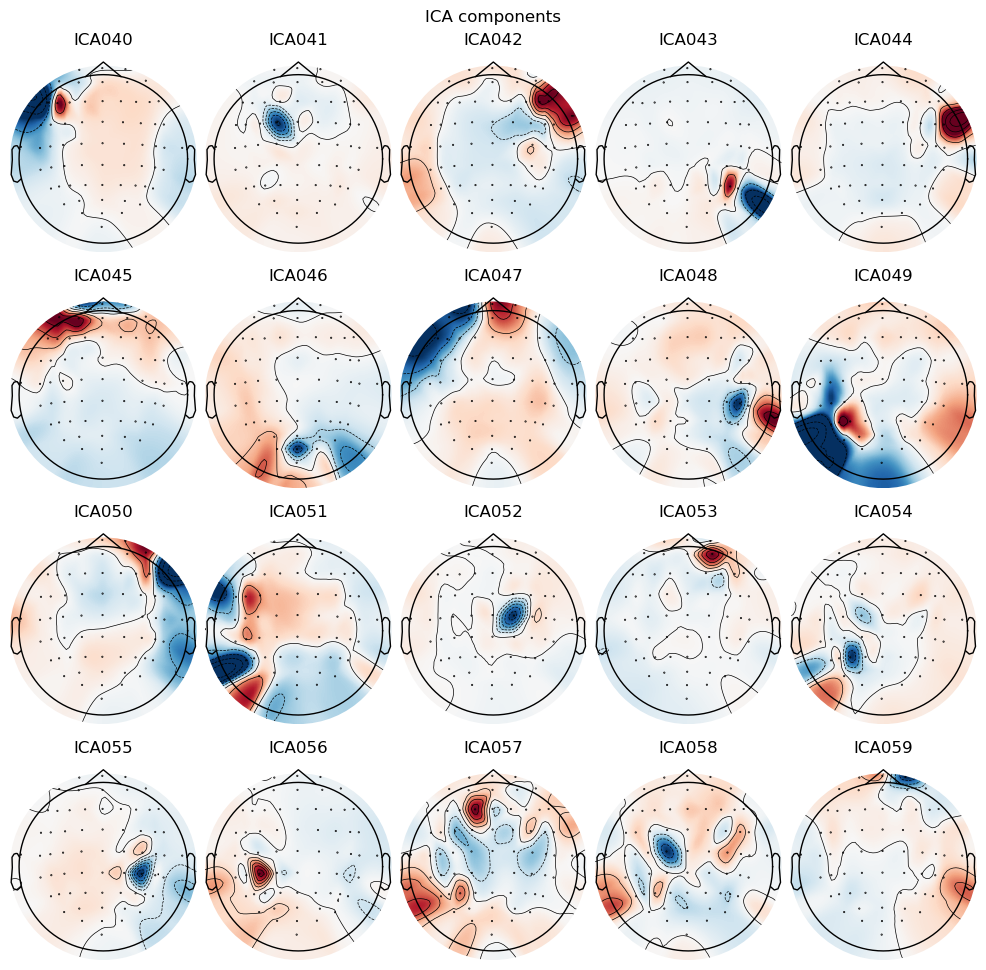

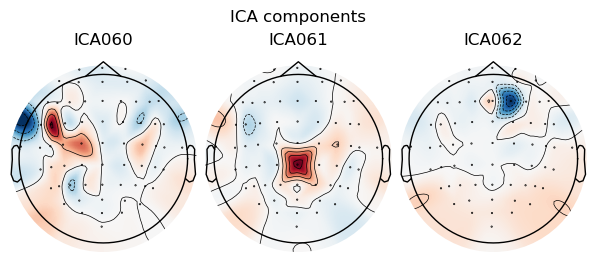

In [221]:
# --- Plot ICA Components ---
ica.plot_components();

Find bad component or artifact component by visual inspection and remove it from the data

In [222]:
# --- Find Bad Components ---
bad_idx, scores = ica.find_bads_eog(stream_filter.copy(), ch_name='T9', threshold=1.5)

Using EOG channel: T9


    Applying projection operator with 1 vector (pre-whitener application)
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 1600 samples (10.000 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 1600 samples (10.000 s)



[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


In [223]:
# --- Remove Bad Components ---
ica.exclude = bad_idx
print(bad_idx)

# --- Plot ICA Components ---
ica.plot_sources(stream_filter.copy());
#stream_filter.plot();

[16, 3, 19, 9, 8, 27, 12, 6, 13, 2, 31, 32, 4, 34]
    Applying projection operator with 1 vector (pre-whitener application)
Creating RawArray with float64 data, n_channels=63, n_times=178080
    Range : 0 ... 178079 =      0.000 ...  1112.994 secs
Ready.


In [224]:
# --- Apply ICA to Filtered Data ---
stream_ica = ica.apply(stream_filter.copy(),exclude=ica.exclude)
#stream_ica.plot();

Applying ICA to Raw instance


    Applying projection operator with 1 vector (pre-whitener application)
    Transforming to ICA space (63 components)
    Zeroing out 14 ICA components
    Projecting back using 64 PCA components


### **Epoch segmentation**

#### **Event marker**

Each event from signal
- T0 = rest
- T1 = Left hand motor imagery
- T2 = Right hand motor imagery

sfreq 160.0
Used Annotations descriptions: ['T0', 'T1', 'T2']
{'T0': 1, 'T1': 2, 'T2': 3}


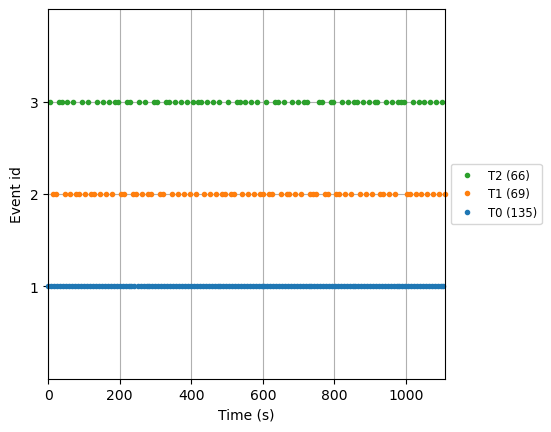

C:\Users\user\AppData\Local\Temp\ipykernel_37668\3407552309.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


In [225]:
# --- Events ---
print("sfreq", stream_filter.info["sfreq"])
events, event_dict = mne.events_from_annotations(stream_filter)
print(event_dict)

# --- Plot Events ---
fig = mne.viz.plot_events(
    events, sfreq=stream_filter.info["sfreq"], first_samp=stream_filter.first_samp, event_id= event_dict
)
ax = fig.axes[0]
x_lim_seconds = [10, 20]
ax.set_xlim(x_lim_seconds)
fig.show()

#### **Epochs**

In [226]:
# Epoch data based on a subset of interested events
event_selected_mi = {'left': 2, 'right': 3}
event_selected_nonmi = {'rest':1, 'left': 2, 'right': 3}

epochs_mi = mne.Epochs(stream_ica.copy().filter(l_freq=8, h_freq=15.0, method = 'iir', iir_params= {"order": 6, "ftype":'butter'}), events, tmin = -2.0, tmax = 5, 
                    event_id = event_selected_mi, preload= True, verbose=False, event_repeated='drop')

epochs_nonmi = mne.Epochs(stream_ica.copy().filter(l_freq=8, h_freq=15.0, method = 'iir', iir_params= {"order": 6, "ftype":'butter'}), events, tmin = -2.0, tmax = 5, 
                    event_id = event_selected_nonmi, preload= True, verbose=False, event_repeated='drop')

Filtering raw data in 9 contiguous segments
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:


- Filter order 24 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 9 contiguous segments
Setting up band-pass filter from 8 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 24 (effective, after forward-backward)
- Cutoffs at 8.00, 15.00 Hz: -6.02, -6.02 dB



In [227]:
epochs_mi
epochs_mi.info

<Info | 10 non-empty values
 bads: []
 ch_names: FC5, FC3, FC1, FCz, FC2, FC4, FC6, C5, C3, C1, Cz, C2, C4, C6, ...
 chs: 64 EEG
 custom_ref_applied: False
 dig: 67 items (3 Cardinal, 64 EEG)
 highpass: 8.0 Hz
 lowpass: 15.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 64
 projs: Average EEG reference: on
 sfreq: 160.0 Hz
 subject_info: 3 items (dict)
>

In [228]:
epochs_nonmi
epochs_nonmi.info

<Info | 10 non-empty values
 bads: []
 ch_names: FC5, FC3, FC1, FCz, FC2, FC4, FC6, C5, C3, C1, Cz, C2, C4, C6, ...
 chs: 64 EEG
 custom_ref_applied: False
 dig: 67 items (3 Cardinal, 64 EEG)
 highpass: 8.0 Hz
 lowpass: 15.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 64
 projs: Average EEG reference: on
 sfreq: 160.0 Hz
 subject_info: 3 items (dict)
>

In [229]:
epochs_mi.to_data_frame()

time condition  epoch        FC5       FC3       FC1        FCz  \
0      -2.00000     right      1  -0.499714 -1.244452 -2.809700  -2.713630   
1      -1.99375     right      1  -0.926894 -2.150215 -3.355594  -2.148676   
2      -1.98750     right      1  -1.048946 -2.568656 -3.079303  -1.045760   
3      -1.98125     right      1  -0.865324 -2.373976 -2.033416   0.310954   
4      -1.97500     right      1  -0.447347 -1.577886 -0.437280   1.614679   
...         ...       ...    ...        ...       ...       ...        ...   
141241  4.97500     right    267  -0.276186 -1.847924 -3.180471  -1.093659   
141242  4.98125     right    267   4.546015  0.998109  0.820740   4.296389   
141243  4.98750     right    267   8.581414  4.022729  4.828133   9.081985   
141244  4.99375     right    267  10.970144  6.585456  7.972755  12.217172   
141245  5.00000     right    267  11.238320  8.126426  9.594412  13.030357   

              FC2       FC4       FC6  ...         P8        PO7        PO3  \
0       -4.459120 -0.755867  3.443501  ...   1.016716  -5.821644  -3.721179   
1       -2.447653  1.664058  4.776706  ...   4.422167  -7.954291  -5.426936   
2        0.124934  3.889610  5.347469  ...   6.786266  -9.539096  -7.084897   
3        2.643670  5.375093  5.024017  ...   7.491369  -9.952544  -8.053399   
4        4.541720  5.757956  3.853617  ...   6.310163  -8.724382  -7.733960   
...           ...       ...       ...  ...        ...        ...        ...   
141241   3.123590  2.901423  3.587451  ...   4.037092 -24.206323 -18.171954   
141242   7.600699  5.133128  1.771808  ... -11.951760 -21.919880 -11.071647   
141243  11.026711  6.695148 -0.161726  ... -26.621786 -16.176112  -2.665940   
141244  12.724431  7.252097 -1.850903  ... -37.318228  -7.578962   5.924347   
141245  12.331574  6.657028 -3.010196  ... -42.025423   2.634294  13.532660   

             POz        PO4        PO8         O1         Oz         O2  \
0       0.220877   0.510001   1.569871  -1.997154   0.837692   3.757669   
1      -0.394275   3.139793   5.479305  -5.209666  -2.478446   3.234461   
2      -1.384537   4.829512   7.882747  -8.380629  -5.710566   1.405609   
3      -2.488317   5.123383   8.156925 -10.582820  -8.186380  -1.497377   
4      -3.387261   3.915800   6.197646 -10.998649  -9.368903  -4.941292   
...          ...        ...        ...        ...        ...        ...   
141241  6.055352  11.973634  15.534171 -14.841982   1.010675  10.591139   
141242  3.163882  -5.342243  -6.057014 -14.647195  -7.472630  -6.895223   
141243 -0.372332 -22.373127 -27.373484 -12.239127 -14.828083 -23.637125   
141244 -3.755117 -36.120156 -44.560923  -7.669931 -19.461704 -36.570941   
141245 -6.266526 -44.082059 -54.417787  -1.471695 -20.376919 -43.310940   

               Iz  
0        0.137728  
1       -1.187222  
2       -2.385863  
3       -3.373684  
4       -4.113482  
...           ...  
141241  -4.079220  
141242 -14.145223  
141243 -21.804734  
141244 -25.373322  
141245 -24.061370  

[141246 rows x 67 columns]

In [230]:
# Selected data from only the channels we are interested in
epochs_mi = epochs_mi.pick_channels(chans_selected)
epochs_nonmi = epochs_nonmi.pick_channels(chans_selected)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


    Using multitaper spectrum estimation with 7 DPSS windows


Averaging across epochs...


c:\Anaconda\lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


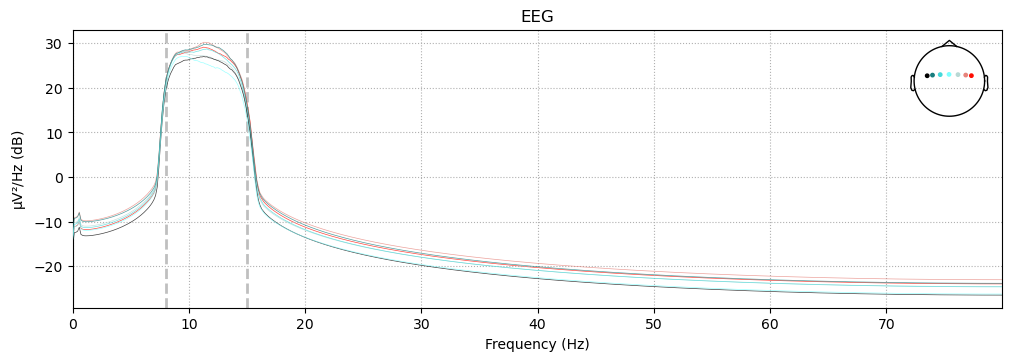

In [231]:
#stream_epochs.plot();
epochs_mi.compute_psd().plot();

### **Baseline Correction**

In [232]:
filt_mi = epochs_mi.copy().filter(l_freq=0.0, h_freq=20.0, method = 'iir', iir_params= {"order": 6, "ftype":'butter'})
filt_nonmi = epochs_nonmi.copy().filter(l_freq=0.0, h_freq=20.0, method = 'iir', iir_params= {"order": 6, "ftype":'butter'})
# filt_mi.plot();
# filt_nonmi.plot();

Setting up low-pass filter at 20 Hz

IIR filter parameters
---------------------
Butterworth lowpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 12 (effective, after forward-backward)
- Cutoff at 20.00 Hz: -6.02 dB

Setting up low-pass filter at 20 Hz

IIR filter parameters
---------------------
Butterworth lowpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 12 (effective, after forward-backward)
- Cutoff at 20.00 Hz: -6.02 dB



In [233]:
stream_mi = filt_mi.copy().apply_baseline((-0.5, 0))
stream_nonmi = filt_nonmi.copy().apply_baseline((-0.5, 0))
# stream_baseline.plot();

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


### **Bad epochs**

#### **Marking bad epochs**

In [234]:
def mark_bad_epochs(epochs, threshold=200e-6):
    reject = dict(eeg=threshold)
    reject.update({'eeg': 150e-6})
    epochs.drop_bad(reject=reject)
    return epochs

mark_bad_epochs(stream_mi.copy())
mark_bad_epochs(stream_nonmi.copy())

0 bad epochs dropped
0 bad epochs dropped


<Epochs |  252 events (all good), -2 – 5 s, baseline -0.5 – 0 s, ~15.1 MB, data loaded,
 'rest': 126
 'left': 63
 'right': 63>

#### **Tuning rejection thresholds**

In [235]:
from ipywidgets import interact

def reject_epochs(reject):
    pick = mne.pick_types(stream_mi.info, meg=False, eeg=True)
    reject = dict(eeg=reject*1e-6)
    evoked = stream_mi.copy().drop_bad(reject=reject, verbose=False).average()
    evoked.plot(spatial_colors=True, gfp=True, time_unit='s')
    print('Number of epochs retained: %d%d' % (evoked.nave, len(stream_mi)))

In [236]:
interact(reject_epochs, reject=(35, 250, 10));

interactive(children=(IntSlider(value=135, description='reject', max=250, min=35, step=10), Output()), _dom_cl…

#### **Autoreject**

In [237]:
import autoreject
from autoreject import get_rejection_threshold

def autoreject_epochs(epochs):
    reject = get_rejection_threshold(epochs)  
    reject.update(reject)
    epochs.drop_bad(reject = reject)
    return epochs

autoreject_epochs(stream_mi.copy())
autoreject_epochs(stream_nonmi.copy())

Estimating rejection dictionary for eeg
0 bad epochs dropped
Estimating rejection dictionary for eeg
0 bad epochs dropped


<Epochs |  252 events (all good), -2 – 5 s, baseline -0.5 – 0 s, ~15.1 MB, data loaded,
 'rest': 126
 'left': 63
 'right': 63>

## **Feature Extraction**

### **Common Spatial Pattern (CSP)**

In [238]:
from mne.decoding import CSP
from sklearn.model_selection import train_test_split, cross_val_score

Computing rank from data with rank=None
    Using tolerance 3.5e-06 (2.2e-16 eps * 7 dim * 2.2e+09  max singular value)
    Estimated rank (mag): 7
    MAG: rank 7 computed from 7 data channels with 0 projectors
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.5e-06 (2.2e-16 eps * 7 dim * 2.3e+09  max singular value)
    Estimated rank (mag): 7
    MAG: rank 7 computed from 7 data channels with 0 projectors
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.


C:\Users\user\AppData\Local\Temp\ipykernel_37668\825569993.py:2: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  X = epochs.get_data()


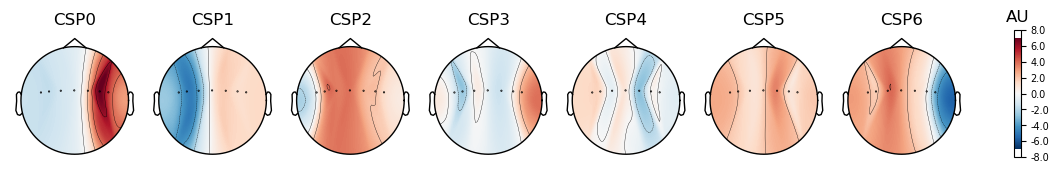

CSP({'component_order': 'mutual_info',
 'cov_est': 'concat',
 'cov_method_params': None,
 'log': None,
 'n_components': 7,
 'norm_trace': False,
 'rank': None,
 'reg': None,
 'transform_into': 'average_power'})
Computing rank from data with rank=None
    Using tolerance 5.1e-06 (2.2e-16 eps * 7 dim * 3.3e+09  max singular value)
    Estimated rank (mag): 7
    MAG: rank 7 computed from 7 data channels with 0 projectors
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.5e-06 (2.2e-16 eps * 7 dim * 2.2e+09  max singular value)
    Estimated rank (mag): 7
    MAG: rank 7 computed from 7 data channels with 0 projectors
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.5e-06 (2.2e-16 eps * 7 dim * 2.3e+09  max singular value)
    Estimated rank (mag): 7
    MAG: rank 7 computed from 7 data channels with 0 projectors
Red

C:\Users\user\AppData\Local\Temp\ipykernel_37668\825569993.py:2: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  X = epochs.get_data()


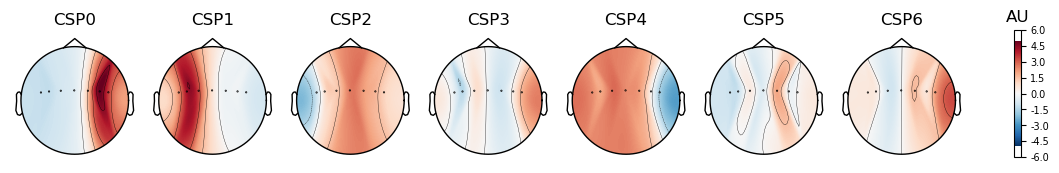

CSP({'component_order': 'mutual_info',
 'cov_est': 'concat',
 'cov_method_params': None,
 'log': None,
 'n_components': 7,
 'norm_trace': False,
 'rank': None,
 'reg': None,
 'transform_into': 'average_power'})


In [239]:
def csp(epochs, n_component = 7): 
    X = epochs.get_data()
    y = epochs.events[:, -1]
    
    # Initilize CSP
    csp = CSP(n_components = n_component, norm_trace = False)
    
    # Fit CSP to data 
    csp.fit(X, y)
    
    # Visualize CSP patterns
    csp.plot_patterns(epochs.info);
    print(csp)
    return X, y, csp
    
X_mi, y_mi, csp_mi = csp(stream_mi.copy(), 7)
X_nonmi, y_nonmi, csp_nonmi = csp(stream_nonmi.copy(), 7)

## **Feature Selection** 

https://johfischer.com/2021/08/06/correlation-based-feature-selection-in-python-from-scratch/

In [240]:
from scipy.stats import pointbiserialr
from math import sqrt

def getMerit(subset, label):
    k = len(subset)

    # average feature-class correlation
    rcf_all = []
    for feature in subset:
        coeff = pointbiserialr( df[label], df[feature] )
        rcf_all.append( abs( coeff.correlation ) )
    rcf = np.mean( rcf_all )

    # average feature-feature correlation
    corr = df[subset].corr()
    corr.values[np.tril_indices_from(corr.values)] = np.nan
    corr = abs(corr)
    rff = corr.unstack().mean()

    return (k * rcf) / sqrt(k + k * (k-1) * rff)

In [241]:
import pandas as pd
import numpy as np

X_transformed = csp_mi.transform(X_mi)
# Assuming X_transformed is a NumPy array
df = pd.DataFrame(X_transformed)
print(df)

# Compute correlation matrix
corr = df.corr()

# corr

            0         1         2         3         4         5         6
0   -1.433118 -1.196960 -0.982217 -1.390532 -1.002372 -1.369535 -1.328301
1   -2.131005 -1.300515 -1.419956 -0.901303 -0.983549 -0.771908 -1.243429
2   -1.251596 -0.845224 -1.104423 -0.754806 -1.194537 -0.884371 -1.018087
3   -1.606029 -1.502412 -1.379196 -1.214219 -1.377689 -1.150587 -1.358104
4   -2.135122 -1.164049 -1.458938 -1.440943 -1.113078 -1.260799 -1.381457
..        ...       ...       ...       ...       ...       ...       ...
121 -0.280615 -0.749543 -0.265369 -0.720438 -0.351135 -0.455292 -0.449975
122 -0.613856 -0.749699 -0.389070 -0.949513 -0.906621 -0.487514 -0.453242
123 -0.424758 -0.965968 -0.408860 -0.717882 -0.561680 -0.534340 -0.821513
124 -1.039362 -1.022151 -0.528357 -1.019600 -0.451977 -0.630692 -0.709082
125 -0.233060 -0.859176 -0.154238 -1.029550 -0.707606 -0.272034 -0.445614

[126 rows x 7 columns]


In [242]:
corr.values[np.tril_indices_from(corr.values)] = np.nan
corr

0         1         2         3         4         5         6
0 NaN  0.489603  0.608873  0.631805  0.499169  0.487361  0.792839
1 NaN       NaN  0.455899  0.516742  0.067950  0.134232  0.527087
2 NaN       NaN       NaN  0.593456  0.591911  0.603413  0.679672
3 NaN       NaN       NaN       NaN  0.582739  0.590622  0.734961
4 NaN       NaN       NaN       NaN       NaN  0.705256  0.490151
5 NaN       NaN       NaN       NaN       NaN       NaN  0.508812
6 NaN       NaN       NaN       NaN       NaN       NaN       NaN

In [243]:
df = df.assign(Class = y_mi)

# name of the label (can be seen in the dataframe)
label = 'Class'

# list with feature names (V1, V2, V3, ...)
features = df.columns.tolist()
features.remove(label)
print(features)

# change class labeling to 0 and 1
df[label] = np.where( df[label] > 2, 1, 0)
df.head()

[0, 1, 2, 3, 4, 5, 6]


0         1         2         3         4         5         6  Class
0 -1.433118 -1.196960 -0.982217 -1.390532 -1.002372 -1.369535 -1.328301      1
1 -2.131005 -1.300515 -1.419956 -0.901303 -0.983549 -0.771908 -1.243429      0
2 -1.251596 -0.845224 -1.104423 -0.754806 -1.194537 -0.884371 -1.018087      0
3 -1.606029 -1.502412 -1.379196 -1.214219 -1.377689 -1.150587 -1.358104      1
4 -2.135122 -1.164049 -1.458938 -1.440943 -1.113078 -1.260799 -1.381457      1

In [244]:
best_value = -1
best_feature = ''
for feature in features:
    coeff = pointbiserialr( df[label], df[feature] )
    abs_coeff = abs( coeff.correlation )
    if abs_coeff > best_value:
        best_value = abs_coeff
        best_feature = feature

print("Feature %s with merit %.4f"%(best_feature, best_value))

Feature 1 with merit 0.1995


In [245]:
class PriorityQueue:
    def  __init__(self):
        self.queue = []

    def isEmpty(self):
        return len(self.queue) == 0
    
    def push(self, item, priority):
        for index, (i, p) in enumerate(self.queue):
            if (set(i) == set(item)):
                if (p >= priority):
                    break
                del self.queue[index]
                self.queue.append( (item, priority) )
                break
        else:
            self.queue.append( (item, priority) )
        
    def pop(self):
        # return item with highest priority and remove it from queue
        max_idx = 0
        for index, (i, p) in enumerate(self.queue):
            if (self.queue[max_idx][1] < p):
                max_idx = index
        (item, priority) = self.queue[max_idx]
        del self.queue[max_idx]
        return (item, priority)

In [246]:
# initialize queue
queue = PriorityQueue()

# push first tuple (subset, merit)
queue.push([best_feature], best_value)

In [247]:
# list for visited nodes
visited = []

# counter for backtracks
n_backtrack = 0

# limit of backtracks
max_backtrack = 5

In [249]:
# repeat until queue is empty
# or the maximum number of backtracks is reached
while not queue.isEmpty():
    # get element of queue with highest merit
    subset, priority = queue.pop()
    
    # check whether the priority of this subset
    # is higher than the current best subset
    if (priority < best_value):
        n_backtrack += 1
    else:
        best_value = priority
        best_subset = subset

    # goal condition
    if (n_backtrack == max_backtrack):
        break
    
    # iterate through all features and look of one can
    # increase the merit
    for feature in features:
        temp_subset = subset + [feature]
        
        # check if this subset has already been evaluated
        for node in visited:
            if (set(node) == set(temp_subset)):
                break
        # if not, ...
        else:
            # ... mark it as visited
            visited.append( temp_subset )
            # ... compute merit
            merit = getMerit(temp_subset, label)
            # and push it to the queue
            queue.push(temp_subset, merit)

In [250]:
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn.metrics import classification_report
import time

# predictors
X = df[features].to_numpy()
# target
Y = df[label].to_numpy()

# get timing
t0 = time.time()

# run SVM with 10-fold cross validation
svc = svm.SVC(kernel='rbf', C=100, gamma=0.01, random_state=42)
scores = cross_val_score(svc, X, Y, cv=10)
best_score = np.mean( scores )

print("Score: %.2f%% (Time: %.4f s)"%(best_score*100, time.time() - t0))

Score: 69.81% (Time: 0.0163 s)


In [251]:
# predictors
# best_subset = [0,1,2,3,4]
X = df[best_subset].to_numpy()

# get timing
t0 = time.time()

# run SVM with 10-fold cross validation
svc = svm.SVC(kernel='rbf', C=100, gamma=0.01, random_state=42)
scores_subset = cross_val_score(svc, X, Y, cv=10)
best_score = np.mean( scores_subset )

print("Score: %.2f%% (Time: %.4f s)"%(best_score*100, time.time() - t0))


Score: 64.10% (Time: 0.0183 s)


## **Classified**

In [252]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

In [253]:
def report(y_test, y_pred, target = ['left','right']):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f"Accuracy: {accuracy}")
    print(f"precision: {precision}")
    print(f"recall: {recall}")
    print(f"f1_score: {f1}")
    
    report = classification_report(y_test, y_pred, target_names=target)  
    print(report)
    print("Confusion matrix \n=======================")
    print(confusion_matrix(y_true=y_test, y_pred=y_pred))

### MI no feature selection [ left right ]

In [254]:
# Transform data into CSP space

X_transformed = csp_mi.transform(X_mi)
print(X_transformed.shape)
print(X_transformed.size)
print(X_transformed)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y_mi, test_size = 0.35, random_state = 56)
print(X_train.shape)
print(X_train.size)

(126, 7)
882
[[-1.43311781 -1.19696014 -0.98221683 -1.39053222 -1.00237211 -1.36953473
  -1.32830074]
 [-2.1310045  -1.30051532 -1.41995641 -0.9013034  -0.98354859 -0.77190769
  -1.24342869]
 [-1.25159601 -0.84522425 -1.10442283 -0.75480616 -1.19453729 -0.88437121
  -1.01808696]
 [-1.60602865 -1.50241247 -1.37919637 -1.21421941 -1.37768926 -1.15058654
  -1.35810375]
 [-2.13512229 -1.16404854 -1.45893756 -1.44094324 -1.11307763 -1.26079942
  -1.3814571 ]
 [-1.67158743 -0.80771307 -1.20351406 -1.10650888 -1.23227584 -1.14983272
  -0.78368295]
 [-0.93885194 -0.60138563 -0.96835825 -0.93866997 -1.21460448 -0.7335332
  -1.18272902]
 [-1.52216222 -0.88669533 -0.36605522 -0.43583181 -0.88413068  0.23771588
  -1.35398767]
 [-1.50074234 -1.55374656 -1.28526659 -1.31110858 -1.03804605 -0.88415712
  -1.43059585]
 [-2.00893692 -0.8810204  -1.05374718 -1.0697684  -1.23378882 -1.18379899
  -1.20075108]
 [-1.44165244 -1.14997416 -0.85396228 -1.33426616 -1.04869181 -1.41366638
  -1.29014284]
 [-1.2707

In [255]:
target = ['left','right']

#### **Logistic Regression**

In [256]:
# Create and fit the logistic regression model within a pipeline
def logistic_regression(X_train, X_test, y_train, y_test, target):
    print("============ logistic_regression ============")
    clf = Pipeline([('LR', LogisticRegression())])
    clf.fit(X_train, y_train)
    
    # Predict and calculate accuracy
    y_pred = clf.predict(X_test)
    report(y_test, y_pred, target)
    print()
    
logistic_regression(X_train, X_test, y_train, y_test, target)

============ logistic_regression ============
Accuracy: 0.7111111111111111
precision: 0.7135555555555555
recall: 0.7111111111111111
f1_score: 0.7119825708061004
              precision    recall  f1-score   support

        left       0.76      0.73      0.75        26
       right       0.65      0.68      0.67        19

    accuracy                           0.71        45
   macro avg       0.71      0.71      0.71        45
weighted avg       0.71      0.71      0.71        45

Confusion matrix 
[[19  7]
 [ 6 13]]



#### **Support Vector Machine**

In [257]:
def svm(X_train, X_test, y_train, y_test, target, kernel='linear',gamma = 'auto'):
    print("============ Support Vector Machine (SVM) kernel("+kernel+") gamma("+str(gamma)+") ============")
    clf = Pipeline([('SVM', SVC(kernel=kernel, gamma=gamma))])  
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    report(y_test, y_pred, target)
    print()

svm(X_train, X_test, y_train, y_test, target)

============ Support Vector Machine (SVM) kernel(linear) gamma(auto) ============
Accuracy: 0.7111111111111111
precision: 0.7316137566137567
recall: 0.7111111111111111
f1_score: 0.7125405464841388
              precision    recall  f1-score   support

        left       0.81      0.65      0.72        26
       right       0.62      0.79      0.70        19

    accuracy                           0.71        45
   macro avg       0.72      0.72      0.71        45
weighted avg       0.73      0.71      0.71        45

Confusion matrix 
[[17  9]
 [ 4 15]]



In [258]:
svm(X_train, X_test, y_train, y_test, target, kernel='rbf',gamma=0.5)

============ Support Vector Machine (SVM) kernel(rbf) gamma(0.5) ============
Accuracy: 0.6666666666666666
precision: 0.6693333333333332
recall: 0.6666666666666666
f1_score: 0.6676721970839619
              precision    recall  f1-score   support

        left       0.72      0.69      0.71        26
       right       0.60      0.63      0.62        19

    accuracy                           0.67        45
   macro avg       0.66      0.66      0.66        45
weighted avg       0.67      0.67      0.67        45

Confusion matrix 
[[18  8]
 [ 7 12]]



#### **Linear Discriminant Analysis**

In [259]:
def lda(X_train, X_test, y_train, y_test, target):
    print("============ Linear Discriminant Analysis (LDA) ============")
    clf = Pipeline([('LDA', LDA())])
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    report(y_test, y_pred, target)
    print()
    
lda(X_train, X_test, y_train, y_test, target)

============ Linear Discriminant Analysis (LDA) ============
Accuracy: 0.6888888888888889
precision: 0.6947089947089947
recall: 0.6888888888888889
f1_score: 0.6904444444444444
              precision    recall  f1-score   support

        left       0.75      0.69      0.72        26
       right       0.62      0.68      0.65        19

    accuracy                           0.69        45
   macro avg       0.68      0.69      0.69        45
weighted avg       0.69      0.69      0.69        45

Confusion matrix 
[[18  8]
 [ 6 13]]



#### **k-NN K Neighbors Classifier**

In [260]:
def knn(X_train, X_test, y_train, y_test, target):
    print("============ K-Nearest Neighbors (KNN) ============")
    clf = KNeighborsClassifier(n_neighbors=3)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    report(y_test, y_pred, target)
    print()

knn(X_train, X_test, y_train, y_test, target)

============ K-Nearest Neighbors (KNN) ============
Accuracy: 0.6444444444444445
precision: 0.6385185185185185
recall: 0.6444444444444445
f1_score: 0.6362278244631185
              precision    recall  f1-score   support

        left       0.67      0.77      0.71        26
       right       0.60      0.47      0.53        19

    accuracy                           0.64        45
   macro avg       0.63      0.62      0.62        45
weighted avg       0.64      0.64      0.64        45

Confusion matrix 
[[20  6]
 [10  9]]



#### **Multi-Layer Perceptron (MLP)**

In [261]:
def mlp(X_train, X_test, y_train, y_test, target, solver='lbfgs', hidden_layer_sizes=(50, 4), random_state=3, max_iter=210):
    print("============ Multi-layer Perceptron (MLP) ============")
    clf = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(50, 4), random_state=3, max_iter=210)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    report(y_test, y_pred, target)
    print()
    
mlp(X_train, X_test, y_train, y_test, target)

============ Multi-layer Perceptron (MLP) ============
Accuracy: 0.6222222222222222
precision: 0.6414021164021164
recall: 0.6222222222222222
f1_score: 0.6240914838638738
              precision    recall  f1-score   support

        left       0.71      0.58      0.64        26
       right       0.54      0.68      0.60        19

    accuracy                           0.62        45
   macro avg       0.63      0.63      0.62        45
weighted avg       0.64      0.62      0.62        45

Confusion matrix 
[[15 11]
 [ 6 13]]



c:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


#### **Convolution Neural Network (CNN)**

In [262]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D,MaxPooling2D, Flatten

#create model
model2 = Sequential()
#add model layers
model2.add(Dense(32, input_dim=7, activation='relu'))
model2.add(Dense(16, activation='relu'))
model2.add(Dense(2, activation='softmax'))

model2.summary()

Model: "sequential_8"
_________________________________________________________________


 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 32)                256       
                                                                 
 dense_25 (Dense)            (None, 16)                528       
                                                                 
 dense_26 (Dense)            (None, 2)                 34        
                                                                 
Total params: 818
Trainable params: 818
Non-trainable params: 0
_________________________________________________________________


In [263]:
y_train_encoded = pd.get_dummies(y_train, columns=[1, 2])
y_test_encoded = pd.get_dummies(y_test, columns=[1, 2])

print(y_train_encoded)

        2      3
0    True  False
1    True  False
2   False   True
3    True  False
4   False   True
..    ...    ...
76  False   True
77  False   True
78  False   True
79   True  False
80  False   True

[81 rows x 2 columns]


In [264]:
#compile model using accuracy to measure model performance
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [265]:
#train the model
history = model2.fit(X_train, y_train_encoded, validation_data=(X_test, y_test_encoded), batch_size=24, epochs=70)

Epoch 1/70
4/4 [==============================] - 0s 50ms/step - loss: 0.6894 - accuracy: 0.5432 - val_loss: 0.6668 - val_accuracy: 0.6444
Epoch 2/70
4/4 [==============================] - 0s 8ms/step - loss: 0.6811 - accuracy: 0.5556 - val_loss: 0.6684 - val_accuracy: 0.6000
Epoch 3/70
4/4 [==============================] - 0s 9ms/step - loss: 0.6788 - accuracy: 0.5802 - val_loss: 0.6710 - val_accuracy: 0.5556
Epoch 4/70
4/4 [==============================] - 0s 9ms/step - loss: 0.6760 - accuracy: 0.6049 - val_loss: 0.6685 - val_accuracy: 0.5778
Epoch 5/70
4/4 [==============================] - 0s 10ms/step - loss: 0.6740 - accuracy: 0.5926 - val_loss: 0.6680 - val_accuracy: 0.5556
Epoch 6/70
4/4 [==============================] - 0s 9ms/step - loss: 0.6731 - accuracy: 0.5679 - val_loss: 0.6679 - val_accuracy: 0.5778
Epoch 7/70
4/4 [==============================] - 0s 9ms/step - loss: 0.6716 - accuracy: 0.5679 - val_loss: 0.6637 - val_accuracy: 0.6000
Epoch 8/70
4/4 [================

In [266]:
score_train = model2.evaluate(X_train, y_train_encoded, verbose=0)
print("Train loss:", score_train[0])
print("Train accuracy:", score_train[1])

Train loss: 0.5729597806930542
Train accuracy: 0.6790123581886292


In [267]:
# Classification report
actual_classes_str = pd.get_dummies(y_test_encoded).idxmax(1)
actual_classes_str = pd.DataFrame(actual_classes_str, index=y_test_encoded.index)

#Predictions on the test set
predicted_classes = np.argmax(model2.predict(X_test),axis=1)
predicted_classes_str = []

for i in predicted_classes:
    if i == 0:
        predicted_classes_str.append(2)
    elif i == 1:
        predicted_classes_str.append(3)
predicted_classes_str = pd.DataFrame(predicted_classes_str,index=y_test_encoded.index)

report(actual_classes_str, predicted_classes_str)

2/2 [==============================] - 0s 2ms/step
Accuracy: 0.7111111111111111
precision: 0.7135555555555555
recall: 0.7111111111111111
f1_score: 0.7119825708061004
              precision    recall  f1-score   support

        left       0.76      0.73      0.75        26
       right       0.65      0.68      0.67        19

    accuracy                           0.71        45
   macro avg       0.71      0.71      0.71        45
weighted avg       0.71      0.71      0.71        45

Confusion matrix 
[[19  7]
 [ 6 13]]


In [268]:
score = model2.evaluate(X_test, y_test_encoded, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.5546855926513672
Test accuracy: 0.7111111283302307


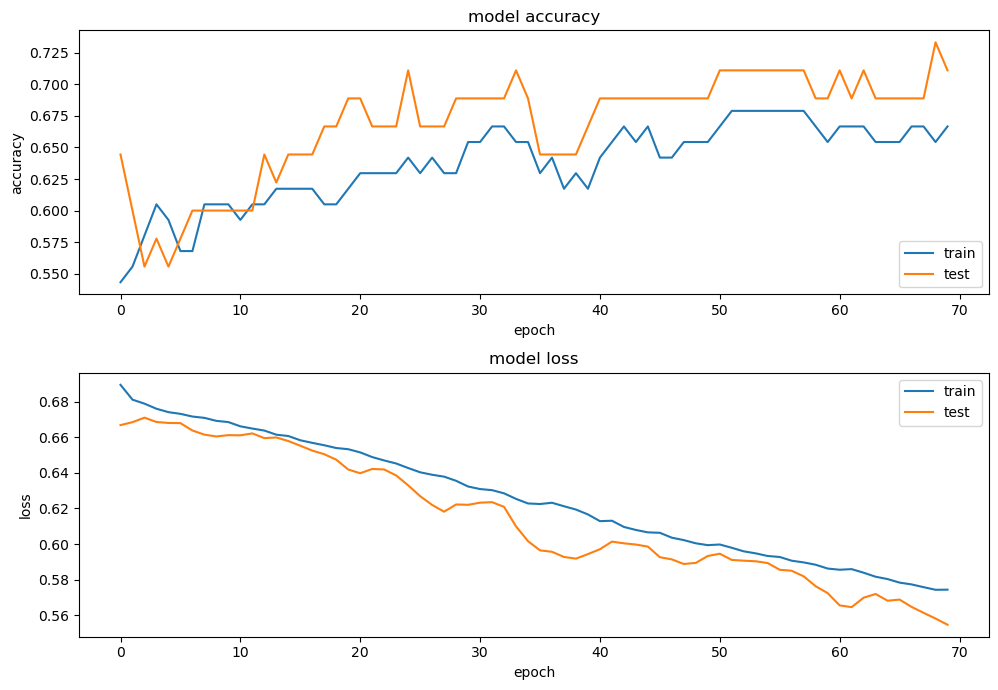

In [269]:
# plotting the metrics
plt.figure(figsize=(10, 7))
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.tight_layout()

In [270]:
predicted_classes = np.argmax(model2.predict(X_test),axis=0)
print(predicted_classes)

2/2 [==============================] - 0s 2ms/step
[2 3]


### MI have feature selection [ left right ]

In [271]:
# Transform data into CSP space

X_transformed = csp_mi.transform(X_mi)
df = pd.DataFrame(X_transformed)
print(X_transformed.shape)
print(X_transformed.size)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df[best_subset], y_mi, test_size = 0.35, random_state = 56)
print(X_train.shape)
print(X_train.size)

(126, 7)
882
(81, 2)
162


In [272]:
target = ['left','right']

#### **Logistic Regression**

In [273]:
# Create and fit the logistic regression model within a pipeline
def logistic_regression(X_train, X_test, y_train, y_test, target):
    print("============ logistic_regression ============")
    clf = Pipeline([('LR', LogisticRegression())])
    clf.fit(X_train, y_train)
    
    # Predict and calculate accuracy
    y_pred = clf.predict(X_test)
    report(y_test, y_pred, target)
    print()
    
logistic_regression(X_train, X_test, y_train, y_test, target)

============ logistic_regression ============
Accuracy: 0.6888888888888889
precision: 0.6947089947089947
recall: 0.6888888888888889
f1_score: 0.6904444444444444
              precision    recall  f1-score   support

        left       0.75      0.69      0.72        26
       right       0.62      0.68      0.65        19

    accuracy                           0.69        45
   macro avg       0.68      0.69      0.69        45
weighted avg       0.69      0.69      0.69        45

Confusion matrix 
[[18  8]
 [ 6 13]]



#### **Support Vector Machine**

In [274]:
def svm(X_train, X_test, y_train, y_test, target, kernel='linear',gamma = 'auto'):
    print("============ Support Vector Machine (SVM) kernel("+kernel+") gamma("+str(gamma)+") ============")
    clf = Pipeline([('SVM', SVC(kernel=kernel, gamma=gamma))])  
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    report(y_test, y_pred, target)
    print()

svm(X_train, X_test, y_train, y_test, target)

============ Support Vector Machine (SVM) kernel(linear) gamma(auto) ============
Accuracy: 0.6444444444444445
precision: 0.6588493631971892
recall: 0.6444444444444445
f1_score: 0.6465608465608467
              precision    recall  f1-score   support

        left       0.73      0.62      0.67        26
       right       0.57      0.68      0.62        19

    accuracy                           0.64        45
   macro avg       0.65      0.65      0.64        45
weighted avg       0.66      0.64      0.65        45

Confusion matrix 
[[16 10]
 [ 6 13]]



In [275]:
svm(X_train, X_test, y_train, y_test, target, kernel='rbf',gamma=0.5)

============ Support Vector Machine (SVM) kernel(rbf) gamma(0.5) ============
Accuracy: 0.5777777777777777
precision: 0.5962962962962963
recall: 0.5777777777777777
f1_score: 0.5798669525537412
              precision    recall  f1-score   support

        left       0.67      0.54      0.60        26
       right       0.50      0.63      0.56        19

    accuracy                           0.58        45
   macro avg       0.58      0.59      0.58        45
weighted avg       0.60      0.58      0.58        45

Confusion matrix 
[[14 12]
 [ 7 12]]



#### **Linear Discriminant Analysis**

In [276]:
def lda(X_train, X_test, y_train, y_test, target):
    print("============ Linear Discriminant Analysis (LDA) ============")
    clf = Pipeline([('LDA', LDA())])
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    report(y_test, y_pred, target)
    print()
    
lda(X_train, X_test, y_train, y_test, target)

============ Linear Discriminant Analysis (LDA) ============
Accuracy: 0.6888888888888889
precision: 0.6947089947089947
recall: 0.6888888888888889
f1_score: 0.6904444444444444
              precision    recall  f1-score   support

        left       0.75      0.69      0.72        26
       right       0.62      0.68      0.65        19

    accuracy                           0.69        45
   macro avg       0.68      0.69      0.69        45
weighted avg       0.69      0.69      0.69        45

Confusion matrix 
[[18  8]
 [ 6 13]]



#### **k-NN K Neighbors Classifier**

In [277]:
def knn(X_train, X_test, y_train, y_test, target):
    print("============ K-Nearest Neighbors (KNN) ============")
    clf = KNeighborsClassifier(n_neighbors=3)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    report(y_test, y_pred, target)
    print()

knn(X_train, X_test, y_train, y_test, target)

============ K-Nearest Neighbors (KNN) ============
Accuracy: 0.6666666666666666
precision: 0.6765480895915679
recall: 0.6666666666666666
f1_score: 0.6686577069852331
              precision    recall  f1-score   support

        left       0.74      0.65      0.69        26
       right       0.59      0.68      0.63        19

    accuracy                           0.67        45
   macro avg       0.67      0.67      0.66        45
weighted avg       0.68      0.67      0.67        45

Confusion matrix 
[[17  9]
 [ 6 13]]



#### **Multi-Layer Perceptron (MLP)**

In [278]:
def mlp(X_train, X_test, y_train, y_test, target, solver='lbfgs', hidden_layer_sizes=(50, 4), random_state=3, max_iter=210):
    print("============ Multi-layer Perceptron (MLP) ============")
    clf = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(50, 4), random_state=3, max_iter=210)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    report(y_test, y_pred, target)
    print()
    
mlp(X_train, X_test, y_train, y_test, target)

============ Multi-layer Perceptron (MLP) ============
Accuracy: 0.6888888888888889
precision: 0.7420217209690895
recall: 0.6888888888888889
f1_score: 0.6462606837606838
              precision    recall  f1-score   support

        left       0.66      0.96      0.78        26
       right       0.86      0.32      0.46        19

    accuracy                           0.69        45
   macro avg       0.76      0.64      0.62        45
weighted avg       0.74      0.69      0.65        45

Confusion matrix 
[[25  1]
 [13  6]]



#### **Convolution Neural Network (CNN)**

In [279]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D,MaxPooling2D, Flatten

#create model
model2 = Sequential()
#add model layers
model2.add(Dense(32, input_dim=2, activation='relu'))
model2.add(Dense(16, activation='relu'))
model2.add(Dense(2, activation='softmax'))

model2.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27 (Dense)            (None, 32)                96        
                                                                 
 dense_28 (Dense)            (None, 16)                528       


                                                                 
 dense_29 (Dense)            (None, 2)                 34        
                                                                 
Total params: 658
Trainable params: 658
Non-trainable params: 0
_________________________________________________________________


In [280]:
y_train_encoded = pd.get_dummies(y_train, columns=[1, 2])
y_test_encoded = pd.get_dummies(y_test, columns=[1, 2])

print(y_train_encoded)

        2      3
0    True  False
1    True  False
2   False   True
3    True  False
4   False   True
..    ...    ...
76  False   True
77  False   True
78  False   True
79   True  False
80  False   True

[81 rows x 2 columns]


In [281]:
#compile model using accuracy to measure model performance
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [282]:
#train the model
history = model2.fit(X_train, y_train_encoded, validation_data=(X_test, y_test_encoded), batch_size=24, epochs=70)

Epoch 1/70
4/4 [==============================] - 0s 50ms/step - loss: 0.7082 - accuracy: 0.4815 - val_loss: 0.6704 - val_accuracy: 0.6667
Epoch 2/70
4/4 [==============================] - 0s 8ms/step - loss: 0.6923 - accuracy: 0.5679 - val_loss: 0.6702 - val_accuracy: 0.6222
Epoch 3/70
4/4 [==============================] - 0s 8ms/step - loss: 0.6815 - accuracy: 0.6296 - val_loss: 0.6706 - val_accuracy: 0.7111
Epoch 4/70
4/4 [==============================] - 0s 8ms/step - loss: 0.6746 - accuracy: 0.5926 - val_loss: 0.6705 - val_accuracy: 0.7111
Epoch 5/70
4/4 [==============================] - 0s 8ms/step - loss: 0.6701 - accuracy: 0.5926 - val_loss: 0.6686 - val_accuracy: 0.7111
Epoch 6/70
4/4 [==============================] - 0s 8ms/step - loss: 0.6661 - accuracy: 0.5926 - val_loss: 0.6671 - val_accuracy: 0.6889
Epoch 7/70
4/4 [==============================] - 0s 9ms/step - loss: 0.6635 - accuracy: 0.6173 - val_loss: 0.6633 - val_accuracy: 0.7111
Epoch 8/70
4/4 [=================

In [283]:
score_train = model2.evaluate(X_train, y_train_encoded, verbose=0)
print("Train loss:", score_train[0])
print("Train accuracy:", score_train[1])

Train loss: 0.5955682396888733
Train accuracy: 0.6666666865348816


In [284]:
# Classification report
actual_classes_str = pd.get_dummies(y_test_encoded).idxmax(1)
actual_classes_str = pd.DataFrame(actual_classes_str, index=y_test_encoded.index)

#Predictions on the test set
predicted_classes = np.argmax(model2.predict(X_test),axis=1)
predicted_classes_str = []

for i in predicted_classes:
    if i == 0:
        predicted_classes_str.append(2)
    elif i == 1:
        predicted_classes_str.append(3)
predicted_classes_str = pd.DataFrame(predicted_classes_str,index=y_test_encoded.index)

report(actual_classes_str, predicted_classes_str)

2/2 [==============================] - 0s 3ms/step
Accuracy: 0.6666666666666666
precision: 0.6693333333333332
recall: 0.6666666666666666
f1_score: 0.6676721970839619
              precision    recall  f1-score   support

        left       0.72      0.69      0.71        26
       right       0.60      0.63      0.62        19

    accuracy                           0.67        45
   macro avg       0.66      0.66      0.66        45
weighted avg       0.67      0.67      0.67        45

Confusion matrix 
[[18  8]
 [ 7 12]]


In [285]:
score = model2.evaluate(X_test, y_test_encoded, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.5719142556190491
Test accuracy: 0.6666666865348816


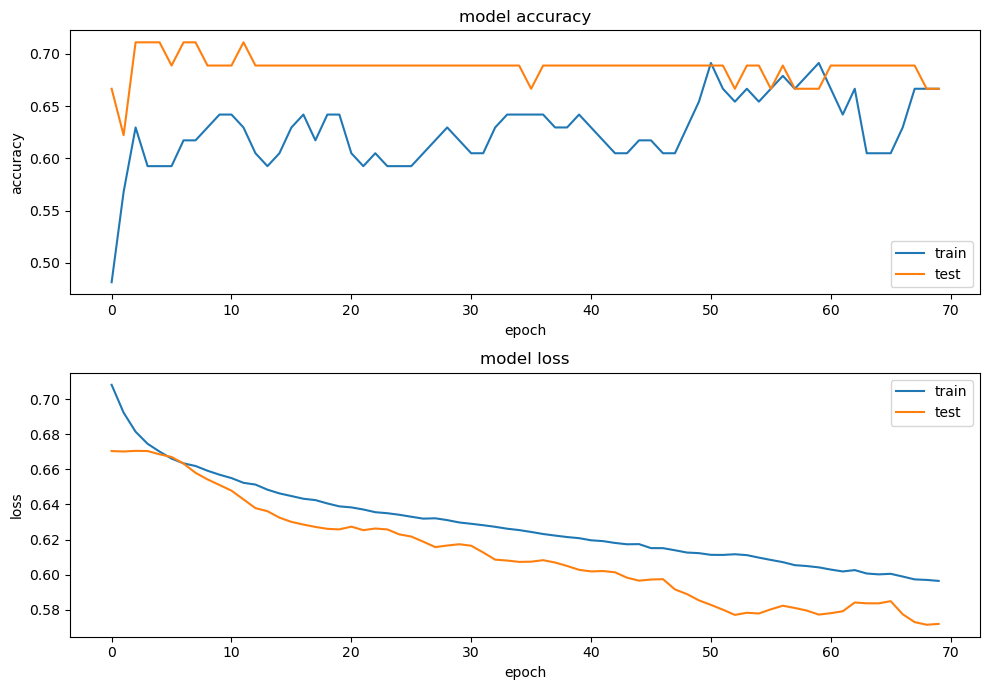

In [286]:
# plotting the metrics
plt.figure(figsize=(10, 7))
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.tight_layout()

In [287]:
predicted_classes = np.argmax(model2.predict(X_test),axis=0)
print(predicted_classes)

2/2 [==============================] - 0s 2ms/step
[2 3]


### MI no feature selection [ rest left right ]

In [288]:
# Transform data into CSP space

X_transformed = csp_nonmi.transform(X_nonmi)
print(X_transformed.shape)
print(X_transformed.size)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y_nonmi, test_size = 0.35, random_state = 56)
print(X_train.shape)
print(X_train.size)

(252, 7)
1764
(163, 7)
1141


In [289]:
target = ['rest','left','right']

#### **Logistic Regression**

In [290]:
# Create and fit the logistic regression model within a pipeline
def logistic_regression(X_train, X_test, y_train, y_test, target):
    print("============ logistic_regression ============")
    clf = Pipeline([('LR', LogisticRegression())])
    clf.fit(X_train, y_train)
    
    # Predict and calculate accuracy
    y_pred = clf.predict(X_test)
    report(y_test, y_pred, target)
    print()
    
logistic_regression(X_train, X_test, y_train, y_test, target)

============ logistic_regression ============
Accuracy: 0.4157303370786517
precision: 0.3602422647366468
recall: 0.4157303370786517
f1_score: 0.3323952035878954
              precision    recall  f1-score   support

        rest       0.45      0.80      0.57        41
        left       0.22      0.10      0.14        20
       right       0.33      0.07      0.12        28

    accuracy                           0.42        89
   macro avg       0.33      0.33      0.28        89
weighted avg       0.36      0.42      0.33        89

Confusion matrix 
[[33  4  4]
 [18  2  0]
 [23  3  2]]



#### **Support Vector Machine**

In [291]:
def svm(X_train, X_test, y_train, y_test, target, kernel='linear',gamma = 'auto'):
    print("============ Support Vector Machine (SVM) kernel("+kernel+") gamma("+str(gamma)+") ============")
    clf = Pipeline([('SVM', SVC(kernel=kernel, gamma=gamma))])  
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    report(y_test, y_pred, target)
    print()

svm(X_train, X_test, y_train, y_test, target)

============ Support Vector Machine (SVM) kernel(linear) gamma(auto) ============
Accuracy: 0.4606741573033708
precision: 0.2122206792071708
recall: 0.4606741573033708
f1_score: 0.2905790838375108
              precision    recall  f1-score   support

        rest       0.46      1.00      0.63        41
        left       0.00      0.00      0.00        20
       right       0.00      0.00      0.00        28

    accuracy                           0.46        89
   macro avg       0.15      0.33      0.21        89
weighted avg       0.21      0.46      0.29        89

Confusion matrix 
[[41  0  0]
 [20  0  0]
 [28  0  0]]



c:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision an

In [292]:
svm(X_train, X_test, y_train, y_test, target, kernel='rbf',gamma=0.5)

============ Support Vector Machine (SVM) kernel(rbf) gamma(0.5) ============
Accuracy: 0.4606741573033708
precision: 0.2122206792071708
recall: 0.4606741573033708
f1_score: 0.2905790838375108
              precision    recall  f1-score   support

        rest       0.46      1.00      0.63        41
        left       0.00      0.00      0.00        20
       right       0.00      0.00      0.00        28

    accuracy                           0.46        89
   macro avg       0.15      0.33      0.21        89
weighted avg       0.21      0.46      0.29        89

Confusion matrix 
[[41  0  0]
 [20  0  0]
 [28  0  0]]



c:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision an

#### **Linear Discriminant Analysis**

In [293]:
def lda(X_train, X_test, y_train, y_test, target):
    print("============ Linear Discriminant Analysis (LDA) ============")
    clf = Pipeline([('LDA', LDA())])
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    report(y_test, y_pred, target)
    print()
    
lda(X_train, X_test, y_train, y_test, target)

============ Linear Discriminant Analysis (LDA) ============
Accuracy: 0.42696629213483145
precision: 0.3699353081375553
recall: 0.42696629213483145
f1_score: 0.36609445136169916
              precision    recall  f1-score   support

        rest       0.47      0.76      0.58        41
        left       0.33      0.25      0.29        20
       right       0.25      0.07      0.11        28

    accuracy                           0.43        89
   macro avg       0.35      0.36      0.33        89
weighted avg       0.37      0.43      0.37        89

Confusion matrix 
[[31  5  5]
 [14  5  1]
 [21  5  2]]



#### **k-NN K Neighbors Classifier**

In [294]:
def knn(X_train, X_test, y_train, y_test, target):
    print("============ K-Nearest Neighbors (KNN) ============")
    clf = KNeighborsClassifier(n_neighbors=3)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    report(y_test, y_pred, target)
    print()

knn(X_train, X_test, y_train, y_test, target)

============ K-Nearest Neighbors (KNN) ============
Accuracy: 0.39325842696629215
precision: 0.36451189260178024
recall: 0.39325842696629215
f1_score: 0.3449928856035434
              precision    recall  f1-score   support

        rest       0.42      0.68      0.52        41
        left       0.29      0.20      0.24        20
       right       0.33      0.11      0.16        28

    accuracy                           0.39        89
   macro avg       0.35      0.33      0.31        89
weighted avg       0.36      0.39      0.34        89

Confusion matrix 
[[28  8  5]
 [15  4  1]
 [23  2  3]]



#### **Multi-Layer Perceptron (MLP)**

In [295]:
def mlp(X_train, X_test, y_train, y_test, target, solver='lbfgs', hidden_layer_sizes=(50, 4), random_state=3, max_iter=210):
    print("============ Multi-layer Perceptron (MLP) ============")
    clf = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(50, 4), random_state=3, max_iter=210)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    report(y_test, y_pred, target)
    print()
    
mlp(X_train, X_test, y_train, y_test, target)

============ Multi-layer Perceptron (MLP) ============
Accuracy: 0.3595505617977528
precision: 0.365114286462601
recall: 0.3595505617977528
f1_score: 0.3587827715355805
              precision    recall  f1-score   support

        rest       0.44      0.41      0.43        41
        left       0.29      0.40      0.33        20
       right       0.32      0.25      0.28        28

    accuracy                           0.36        89
   macro avg       0.35      0.35      0.35        89
weighted avg       0.37      0.36      0.36        89

Confusion matrix 
[[17 14 10]
 [ 7  8  5]
 [15  6  7]]



c:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


#### **Convolution Neural Network (CNN)**

In [296]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D,MaxPooling2D, Flatten

#create model
model2 = Sequential()
#add model layers
model2.add(Dense(32, input_dim=7, activation='relu'))
model2.add(Dense(16, activation='relu'))
model2.add(Dense(3, activation='softmax'))

model2.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 32)                256       
                                                                 
 dense_31 (Dense)            (None, 16)                528       
                                                                 
 dense_32 (Dense)            (None, 3)                 51        
                                                                 
Total params: 835
Trainable params: 835
Non-trainable params: 0
_________________________________________________________________


In [297]:
y_train_encoded = pd.get_dummies(y_train, columns=[1, 2])
y_test_encoded = pd.get_dummies(y_test, columns=[1, 2])

print(y_train_encoded)

         1      2      3
0    False   True  False
1     True  False  False
2     True  False  False
3     True  False  False
4    False  False   True
..     ...    ...    ...
158  False  False   True
159  False   True  False
160   True  False  False
161  False   True  False
162   True  False  False

[163 rows x 3 columns]


In [298]:
#compile model using accuracy to measure model performance
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [299]:
#train the model
history = model2.fit(X_train, y_train_encoded, validation_data=(X_test, y_test_encoded), batch_size=24, epochs=70)

Epoch 1/70
7/7 [==============================] - 0s 26ms/step - loss: 1.0908 - accuracy: 0.3620 - val_loss: 1.1026 - val_accuracy: 0.2697
Epoch 2/70
7/7 [==============================] - 0s 5ms/step - loss: 1.0641 - accuracy: 0.4479 - val_loss: 1.0877 - val_accuracy: 0.3820
Epoch 3/70
7/7 [==============================] - 0s 5ms/step - loss: 1.0424 - accuracy: 0.5399 - val_loss: 1.0774 - val_accuracy: 0.4270
Epoch 4/70
7/7 [==============================] - 0s 5ms/step - loss: 1.0275 - accuracy: 0.5031 - val_loss: 1.0714 - val_accuracy: 0.4607
Epoch 5/70
7/7 [==============================] - 0s 5ms/step - loss: 1.0130 - accuracy: 0.5337 - val_loss: 1.0717 - val_accuracy: 0.4494
Epoch 6/70
7/7 [==============================] - 0s 5ms/step - loss: 1.0040 - accuracy: 0.5276 - val_loss: 1.0736 - val_accuracy: 0.4607
Epoch 7/70
7/7 [==============================] - 0s 5ms/step - loss: 0.9938 - accuracy: 0.5399 - val_loss: 1.0770 - val_accuracy: 0.4607
Epoch 8/70
7/7 [=================

In [300]:
score_train = model2.evaluate(X_train, y_train_encoded, verbose=0)
print("Train loss:", score_train[0])
print("Train accuracy:", score_train[1])

Train loss: 0.809731125831604
Train accuracy: 0.6319018602371216


In [301]:
# Classification report
actual_classes_str = pd.get_dummies(y_test_encoded).idxmax(1)
actual_classes_str = pd.DataFrame(actual_classes_str, index=y_test_encoded.index)

#Predictions on the test set
predicted_classes = np.argmax(model2.predict(X_test),axis=1)
predicted_classes_str = []

for i in predicted_classes:
    if i == 0:
        predicted_classes_str.append(1)
    elif i == 1:
        predicted_classes_str.append(2)
    elif i == 2:
        predicted_classes_str.append(3)
predicted_classes_str = pd.DataFrame(predicted_classes_str,index=y_test_encoded.index)

report(actual_classes_str, predicted_classes_str, target)

3/3 [==============================] - 0s 1ms/step
Accuracy: 0.39325842696629215
precision: 0.3114107365792759
recall: 0.39325842696629215
f1_score: 0.3061541200247128
              precision    recall  f1-score   support

        rest       0.43      0.78      0.55        41
        left       0.20      0.05      0.08        20
       right       0.22      0.07      0.11        28

    accuracy                           0.39        89
   macro avg       0.28      0.30      0.25        89
weighted avg       0.31      0.39      0.31        89

Confusion matrix 
[[32  2  7]
 [19  1  0]
 [24  2  2]]


In [302]:
score = model2.evaluate(X_test, y_test_encoded, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 1.1144864559173584
Test accuracy: 0.3932584226131439


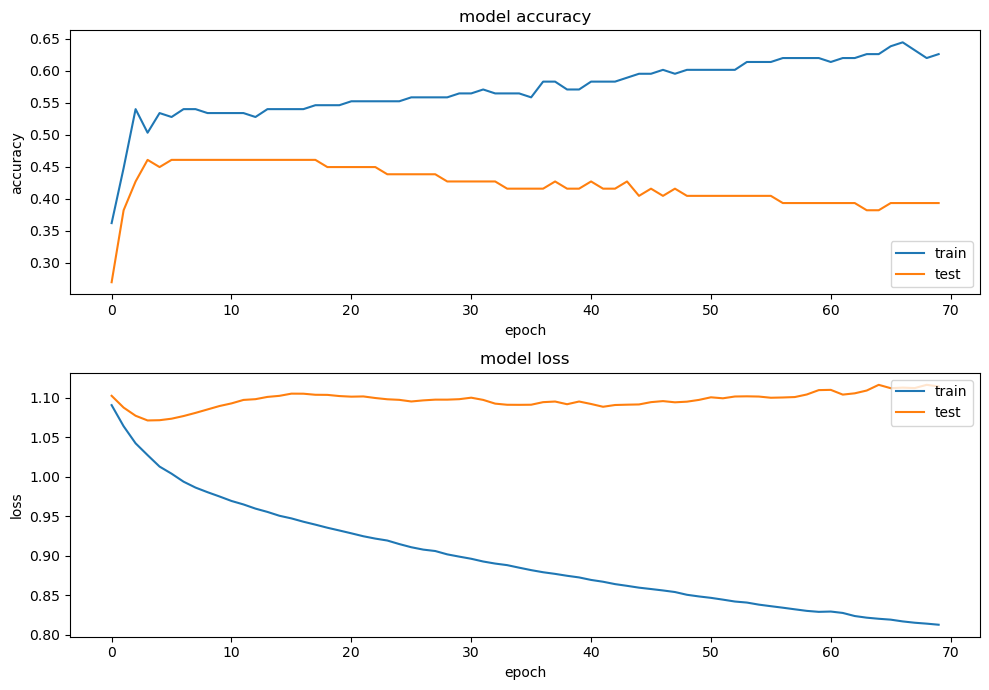

In [303]:
# plotting the metrics
plt.figure(figsize=(10, 7))
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.tight_layout()

In [304]:
predicted_classes = np.argmax(model2.predict(X_test),axis=0)
print(predicted_classes)

3/3 [==============================] - 0s 2ms/step
[36 11 57]


### MI no feature selection [ left right ]

In [305]:
# Transform data into CSP space

X_transformed = csp_nonmi.transform(X_nonmi)
print(X_transformed.shape)
print(X_transformed.size)

y = [2 if x == 3 else x for x in y_nonmi]
print(y)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size = 0.35, random_state = 56)
print(X_train.shape)
print(X_train.size)

(252, 7)
1764
[2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1]
(163, 7)
1141


In [306]:
target = ['non-MI', 'MI']

#### **Logistic Regression**

In [307]:
# Create and fit the logistic regression model within a pipeline
def logistic_regression(X_train, X_test, y_train, y_test, target):
    print("============ logistic_regression ============")
    clf = Pipeline([('LR', LogisticRegression())])
    clf.fit(X_train, y_train)
    
    # Predict and calculate accuracy
    y_pred = clf.predict(X_test)
    report(y_test, y_pred, target)
    print()
    
logistic_regression(X_train, X_test, y_train, y_test, target)

============ logistic_regression ============
Accuracy: 0.5168539325842697
precision: 0.5425073496838629
recall: 0.5168539325842697
f1_score: 0.49846623759136033
              precision    recall  f1-score   support

      non-MI       0.48      0.73      0.58        41
          MI       0.59      0.33      0.43        48

    accuracy                           0.52        89
   macro avg       0.54      0.53      0.50        89
weighted avg       0.54      0.52      0.50        89

Confusion matrix 
[[30 11]
 [32 16]]



#### **Support Vector Machine**

In [308]:
def svm(X_train, X_test, y_train, y_test, target, kernel='linear',gamma = 'auto'):
    print("============ Support Vector Machine (SVM) kernel("+kernel+") gamma("+str(gamma)+") ============")
    clf = Pipeline([('SVM', SVC(kernel=kernel, gamma=gamma))])  
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    report(y_test, y_pred, target)
    print()

svm(X_train, X_test, y_train, y_test, target)

============ Support Vector Machine (SVM) kernel(linear) gamma(auto) ============
Accuracy: 0.5393258426966292
precision: 0.5650910499806276
recall: 0.5393258426966292
f1_score: 0.5258201582598067
              precision    recall  f1-score   support

      non-MI       0.50      0.73      0.59        41
          MI       0.62      0.38      0.47        48

    accuracy                           0.54        89
   macro avg       0.56      0.55      0.53        89
weighted avg       0.57      0.54      0.53        89

Confusion matrix 
[[30 11]
 [30 18]]



In [309]:
svm(X_train, X_test, y_train, y_test, target, kernel='rbf',gamma=0.5)

============ Support Vector Machine (SVM) kernel(rbf) gamma(0.5) ============
Accuracy: 0.47191011235955055
precision: 0.499301548739751
recall: 0.47191011235955055
f1_score: 0.409370274734222
              precision    recall  f1-score   support

      non-MI       0.46      0.83      0.59        41
          MI       0.53      0.17      0.25        48

    accuracy                           0.47        89
   macro avg       0.50      0.50      0.42        89
weighted avg       0.50      0.47      0.41        89

Confusion matrix 
[[34  7]
 [40  8]]



#### **Linear Discriminant Analysis**

In [310]:
def lda(X_train, X_test, y_train, y_test, target):
    print("============ Linear Discriminant Analysis (LDA) ============")
    clf = Pipeline([('LDA', LDA())])
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    report(y_test, y_pred, target)
    print()
    
lda(X_train, X_test, y_train, y_test, target)

============ Linear Discriminant Analysis (LDA) ============
Accuracy: 0.5168539325842697
precision: 0.5425073496838629
recall: 0.5168539325842697
f1_score: 0.49846623759136033
              precision    recall  f1-score   support

      non-MI       0.48      0.73      0.58        41
          MI       0.59      0.33      0.43        48

    accuracy                           0.52        89
   macro avg       0.54      0.53      0.50        89
weighted avg       0.54      0.52      0.50        89

Confusion matrix 
[[30 11]
 [32 16]]



#### **k-NN K Neighbors Classifier**

In [311]:
def knn(X_train, X_test, y_train, y_test, target):
    print("============ K-Nearest Neighbors (KNN) ============")
    clf = KNeighborsClassifier(n_neighbors=3)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    report(y_test, y_pred, target)
    print()

knn(X_train, X_test, y_train, y_test, target)

============ K-Nearest Neighbors (KNN) ============
Accuracy: 0.5280898876404494
precision: 0.5433996274710088
recall: 0.5280898876404494
f1_score: 0.5222149904083311
              precision    recall  f1-score   support

      non-MI       0.49      0.66      0.56        41
          MI       0.59      0.42      0.49        48

    accuracy                           0.53        89
   macro avg       0.54      0.54      0.53        89
weighted avg       0.54      0.53      0.52        89

Confusion matrix 
[[27 14]
 [28 20]]



#### **Multi-Layer Perceptron (MLP)**

In [312]:
def mlp(X_train, X_test, y_train, y_test, target, solver='lbfgs', hidden_layer_sizes=(50, 4), random_state=3, max_iter=210):
    print("============ Multi-layer Perceptron (MLP) ============")
    clf = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(50, 4), random_state=3, max_iter=210)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    report(y_test, y_pred, target)
    print()
    
mlp(X_train, X_test, y_train, y_test, target)

============ Multi-layer Perceptron (MLP) ============
Accuracy: 0.5056179775280899
precision: 0.5191612089166616
recall: 0.5056179775280899
f1_score: 0.49946332328491827
              precision    recall  f1-score   support

      non-MI       0.47      0.63      0.54        41
          MI       0.56      0.40      0.46        48

    accuracy                           0.51        89
   macro avg       0.52      0.51      0.50        89
weighted avg       0.52      0.51      0.50        89

Confusion matrix 
[[26 15]
 [29 19]]



c:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


#### **Convolution Neural Network (CNN)**

In [313]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D,MaxPooling2D, Flatten

#create model
model2 = Sequential()
#add model layers
model2.add(Dense(32, input_dim=7, activation='relu'))
model2.add(Dense(16, activation='relu'))
model2.add(Dense(2, activation='softmax'))

model2.summary()

Model: "sequential_11"
_________________________________________________________________


 Layer (type)                Output Shape              Param #   
 dense_33 (Dense)            (None, 32)                256       
                                                                 
 dense_34 (Dense)            (None, 16)                528       
                                                                 
 dense_35 (Dense)            (None, 2)                 34        
                                                                 
Total params: 818
Trainable params: 818
Non-trainable params: 0
_________________________________________________________________


In [314]:
y_train_encoded = pd.get_dummies(y_train, columns=[1, 2])
y_test_encoded = pd.get_dummies(y_test, columns=[1, 2])

print(y_train_encoded)

         1      2
0    False   True
1     True  False
2     True  False
3     True  False
4    False   True
..     ...    ...
158  False   True
159  False   True
160   True  False
161  False   True
162   True  False

[163 rows x 2 columns]


In [315]:
#compile model using accuracy to measure model performance
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [316]:
#train the model
history = model2.fit(X_train, y_train_encoded, validation_data=(X_test, y_test_encoded), batch_size=24, epochs=70)

Epoch 1/70
7/7 [==============================] - 0s 26ms/step - loss: 0.7036 - accuracy: 0.4969 - val_loss: 0.6874 - val_accuracy: 0.5056
Epoch 2/70
7/7 [==============================] - 0s 5ms/step - loss: 0.6985 - accuracy: 0.5276 - val_loss: 0.6871 - val_accuracy: 0.5281
Epoch 3/70
7/7 [==============================] - 0s 5ms/step - loss: 0.6959 - accuracy: 0.5276 - val_loss: 0.6874 - val_accuracy: 0.5618
Epoch 4/70
7/7 [==============================] - 0s 5ms/step - loss: 0.6937 - accuracy: 0.5337 - val_loss: 0.6883 - val_accuracy: 0.5393
Epoch 5/70
7/7 [==============================] - 0s 6ms/step - loss: 0.6916 - accuracy: 0.5215 - val_loss: 0.6889 - val_accuracy: 0.5281
Epoch 6/70
7/7 [==============================] - 0s 5ms/step - loss: 0.6903 - accuracy: 0.5276 - val_loss: 0.6896 - val_accuracy: 0.5506
Epoch 7/70
7/7 [==============================] - 0s 5ms/step - loss: 0.6894 - accuracy: 0.5276 - val_loss: 0.6905 - val_accuracy: 0.5056
Epoch 8/70
7/7 [=================

In [317]:
score_train = model2.evaluate(X_train, y_train_encoded, verbose=0)
print("Train loss:", score_train[0])
print("Train accuracy:", score_train[1])

Train loss: 0.6180633306503296
Train accuracy: 0.6809815764427185


In [318]:
# Classification report
actual_classes_str = pd.get_dummies(y_test_encoded).idxmax(1)
actual_classes_str = pd.DataFrame(actual_classes_str, index=y_test_encoded.index)

#Predictions on the test set
predicted_classes = np.argmax(model2.predict(X_test),axis=1)
predicted_classes_str = []

for i in predicted_classes:
    if i == 0:
        predicted_classes_str.append(1)
    elif i == 1:
        predicted_classes_str.append(2)
predicted_classes_str = pd.DataFrame(predicted_classes_str,index=y_test_encoded.index)

report(actual_classes_str, predicted_classes_str, target)

3/3 [==============================] - 0s 2ms/step
Accuracy: 0.43820224719101125
precision: 0.44635140140758117
recall: 0.43820224719101125
f1_score: 0.41411268658459677
              precision    recall  f1-score   support

      non-MI       0.43      0.66      0.52        41
          MI       0.46      0.25      0.32        48

    accuracy                           0.44        89
   macro avg       0.45      0.45      0.42        89
weighted avg       0.45      0.44      0.41        89

Confusion matrix 
[[27 14]
 [36 12]]


In [319]:
score = model2.evaluate(X_test, y_test_encoded, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.7307825684547424
Test accuracy: 0.43820226192474365


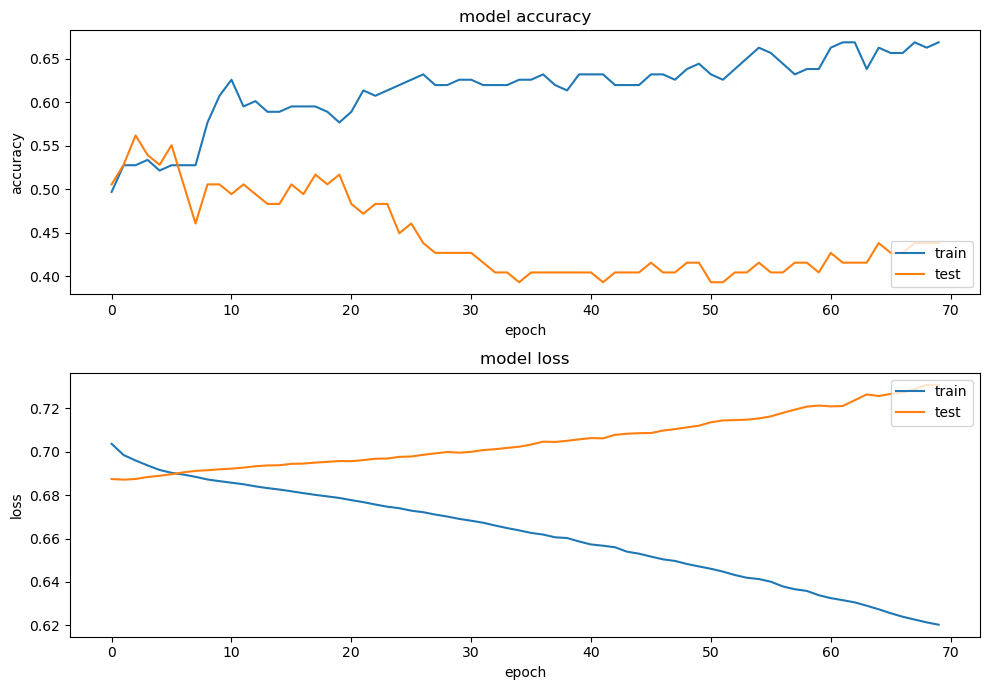

In [320]:
# plotting the metrics
plt.figure(figsize=(10, 7))
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.tight_layout()

In [321]:
predicted_classes = np.argmax(model2.predict(X_test),axis=0)
print(predicted_classes)

3/3 [==============================] - 0s 2ms/step
[39 11]
